In [1]:
import os
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import load
from torch import FloatTensor
from machine_learning.DNN.model import DNN
from machine_learning.DNN.data_pipepline import CarData
from torch.utils.data import DataLoader

c:\Users\~MatthijsvanGroening\.conda\envs\sdp_cars\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = './data'

# data params
label_col = 'price'
norm_feats = ['year', 'odometer', 'cylinders', 'lat', 'long']
label_norm = 'standard'

# training params
batch_size = 32
val_size = 0.1
test_size = 0.1

# data files
train_features_file = os.path.join(data_dir, 'cleaned_data_train.parquet')
train_label_file = os.path.join(data_dir, 'cleaned_price_train.parquet')
val_features_file = os.path.join(data_dir, 'cleaned_data_val.parquet')
val_label_file = os.path.join(data_dir, 'cleaned_price_val.parquet')
test_features_file = os.path.join(data_dir, 'cleaned_data_test.parquet')
test_label_file = os.path.join(data_dir, 'cleaned_price_test.parquet')

data = CarData()
data.load_from_files(train_features_file, train_label_file, val_features_file, 
                     val_label_file,  test_features_file, test_label_file,
                     norm_feats, label_norm='standard')

train_data = DataLoader(data.train_data, batch_size=batch_size, shuffle=True)
val_data = DataLoader(data.val_data, batch_size=batch_size, shuffle=True)

In [3]:
# model params
input_dim = len(data.train_data.dataset[0][0])
hidden_dims = [512, 256, 256, 128]
output_dim = 1

# training params
learning_rate = 0.001
n_epochs = 100
l2_reg = 1e-5

model_save_dir = f"./machine_learning/DNN/models/arc_{'_'.join([str(i) for i in hidden_dims])}_lr_{learning_rate}_l2_{l2_reg}"

In [4]:
model = DNN(hidden_dims=hidden_dims, input_dim=input_dim, output_dim=output_dim)
model.load_state_dict(load(os.path.join(model_save_dir, 'model_parameters')))

<All keys matched successfully>

In [5]:
# Meta data
dataset = data.val_data.dataset
feature_means = data.feature_means
feature_stds = data.feature_stds
label_mean = data.label_mean
label_std = data.label_std

numeric_columns = data.numeric_features
onehot_columns = data.onehot_features
categorical_cols = data.categorical_features

def test_model(model, data, label_column, label_mean, label_std):
    if type(data) == list:
        X = np.concatenate([instance[0][None, ...] for instance in data], axis=0)
        y_true = np.concatenate([instance[1][None, ...] for instance in data], axis=0)
    else:
        X = data.drop(columns=[label_column]).copy().to_numpy()
        y_true = data[[label_column]].copy().to_numpy()
    
    model.eval()
    y_pred = model(FloatTensor(X)).detach().numpy()

    # Reconstruct data
    y_pred = (y_pred * label_std) + label_mean
    y_true = (y_true * label_std) + label_mean
    return y_pred[:, 0], y_true[:, 0]

In [19]:
test_dataset = data.test_data.dataset
y1, y2 = test_model(model, test_dataset, label_col, label_mean, label_std)

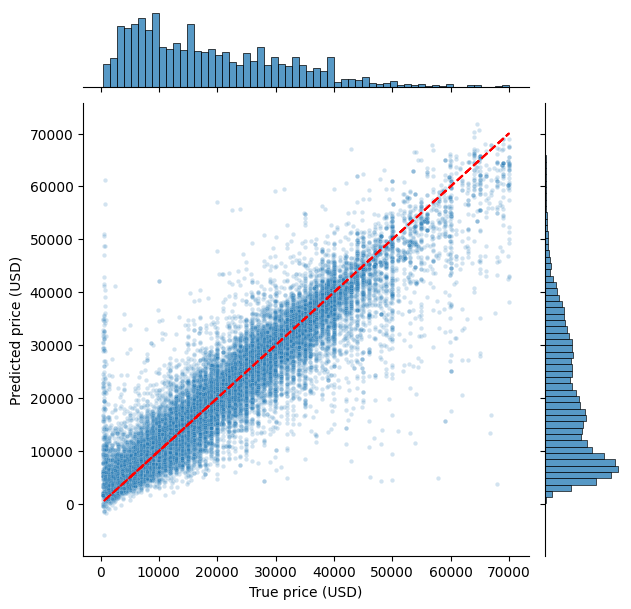

In [20]:
sns.jointplot(x = y2, y = y1, kind = 'scatter', alpha = 0.2, s = 10)
plt.plot(y2, y2, 'r--')
plt.xlabel('True price (USD)')
plt.ylabel('Predicted price (USD)')
plt.show()

Mean true price: 19257.777398227092
Mean pred price: 19270.186
RMSE: 4621.565534704487
RMSPE: 265.3392476267567
MAPE: 40.094734767928436
MAE: 2802.483847542664
MedAE: 1675.39990234375


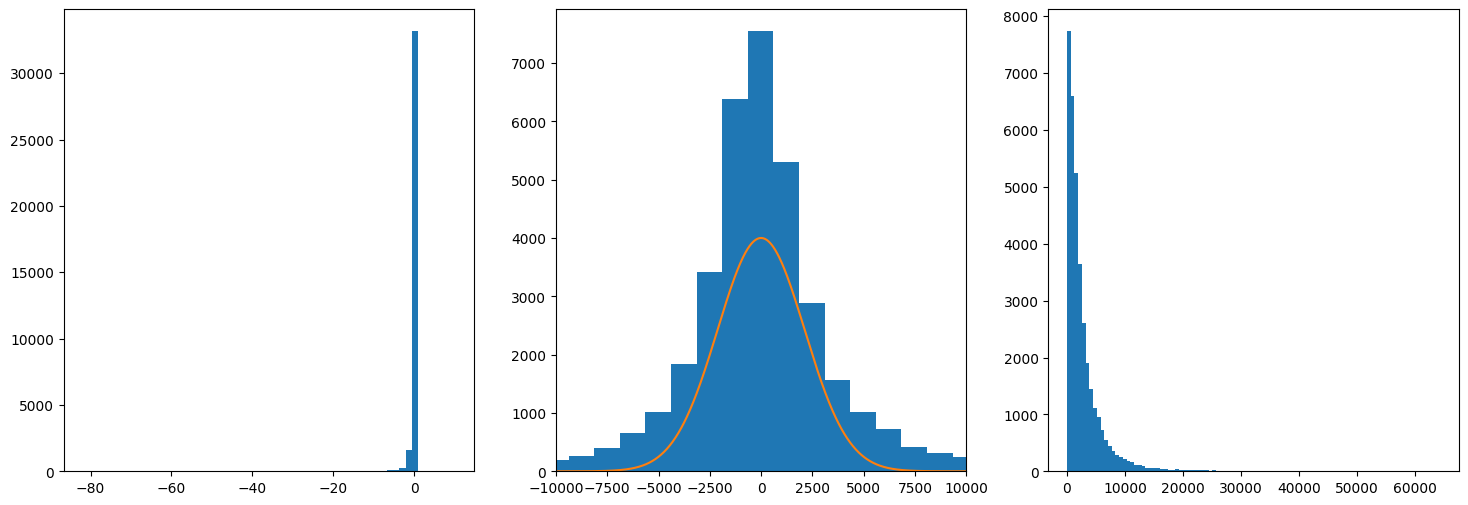

In [21]:
print('Mean true price:', np.mean(y2))
print('Mean pred price:', np.mean(y1))
print('RMSE:', np.sqrt(np.mean(np.square(y1 - y2))))
print('RMSPE:', np.sqrt(np.mean(np.square((y2 - y1) / y2))) * 100)
print('MAPE:', np.mean(np.abs((y2 - y1) / y2)) * 100)
print('MAE:', np.mean(np.abs(y1 - y2)))
print('MedAE:', np.median(np.abs(y1 - y2)))

a = 4000
sigma = 3000

x = np.linspace(-10000, 10000, 1000)
y = a * np.exp(- x**2 / sigma**2)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist((y2 - y1) / y2, bins=60)
# ax[0].set_yscale('log')

ax[1].hist((y2 - y1), bins=100)
ax[1].plot(x, y)
ax[1].set_xlim(-10000, 10000)
# ax[1].set_yscale('log')

ax[2].hist(np.abs(y2 - y1), bins=100)
# ax[2].set_yscale('log')
plt.show()

In [26]:
X_train = FloatTensor(np.concatenate([instance[0][None, ...] for instance in data.train_data.dataset[:2000]], axis=0))
X_val = FloatTensor(np.concatenate([instance[0][None, ...] for instance in data.test_data.dataset[:1000]], axis=0))
e = shap.DeepExplainer(model, X_train)

In [27]:
shap_values = e.shap_values(X_val)
shap_values.shape

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(1000, 106)

In [28]:
df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": data.train_features
})
df.sort_values("mean_abs_shap", ascending=False)[:20]

,mean_abs_shap,stdev_abs_shap,name
0,0.305236,0.199404,year
1,0.201903,0.128423,odometer
2,0.089227,0.107077,cylinders
71,0.075833,0.054693,drive_fwd
88,0.054926,0.046663,type_sedan
73,0.043167,0.026298,drive_None
54,0.041086,0.081217,fuel_diesel
56,0.037671,0.047464,fuel_gas
66,0.036196,0.028902,transmission_automatic
4,0.035688,0.042569,long


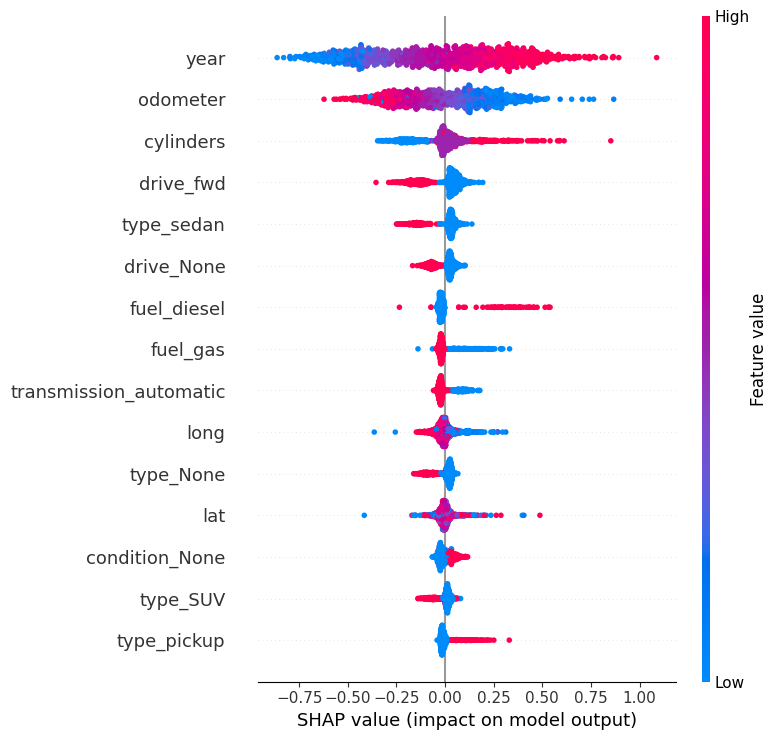

In [30]:
shap.summary_plot(shap_values, features=X_val, feature_names=data.train_features, max_display=15)

In [13]:
train_features_file = os.path.join(data_dir, 'cleaned_data_train.parquet')
train_label_file = os.path.join(data_dir, 'cleaned_price_train.parquet')

train_features_data = pd.read_parquet(train_features_file)
train_label_data = pd.read_parquet(train_label_file)
train_data = pd.concat([train_label_data, train_features_data], axis=1)

In [56]:
all_data = data.train_data.dataset
y1, y2 = test_model(model, all_data, label_col, label_mean, label_std)
X = np.concatenate([instance[0][None, ...] for instance in all_data], axis=0)
y_true = np.concatenate([instance[1][None, ...] for instance in all_data], axis=0)
all_data = pd.DataFrame(X, columns=data.train_features)
all_data['price'] = y_true
all_data['pred_price'] = y1


subset = [instance for instance in data.train_data.dataset if instance[1] <= (1000 - label_mean) / label_std]
y1, y2 = test_model(model, subset, label_col, label_mean, label_std)
X = np.concatenate([instance[0][None, ...] for instance in subset], axis=0)
y_true = np.concatenate([instance[1][None, ...] for instance in subset], axis=0)
subset = pd.DataFrame(X, columns=data.train_features)
subset['price'] = y_true
subset['pred_price'] = y1

subset = subset[subset['pred_price'] > 10000].copy()
for col in subset.columns.to_list():
    print(col)
    print('outliers:', subset[col].mean())
    print('overall: ', all_data[col].mean())
    print(' ')


year
outliers: 0.6980157918113425
overall:  1.5180376145926866e-14
 
odometer
outliers: -0.6265479586526705
overall:  -1.1278694931851624e-16
 
cylinders
outliers: 0.17481040550275645
overall:  2.9184688819880175e-16
 
lat
outliers: 0.34207745240194054
overall:  -4.0631385654896333e-16
 
long
outliers: -0.31918299843931097
overall:  2.251476251513911e-15
 
manufacturer_acura
outliers: 0.00819672131147541
overall:  0.015379294768640072
 
manufacturer_alfa-romeo
outliers: 0.0
overall:  0.0022020835097823323
 
manufacturer_aston-martin
outliers: 0.0
overall:  3.5289799836255327e-05
 
manufacturer_audi
outliers: 0.0194672131147541
overall:  0.01959289686908896
 
manufacturer_bmw
outliers: 0.018442622950819672
overall:  0.03634143587137574
 
manufacturer_buick
outliers: 0.0020491803278688526
overall:  0.013254848818497502
 
manufacturer_cadillac
outliers: 0.017418032786885244
overall:  0.016483865503514866
 
manufacturer_chevrolet
outliers: 0.1444672131147541
overall:  0.12279438751023404
 

In [50]:
thing = [instance for instance in data.val_data.dataset if instance[1] <= 1000]
print([inst[1] for inst in thing[:5]])

[array([1.02167498]), array([0.42894231]), array([0.64906626]), array([-0.49798121]), array([2.50498994])]


The palette list has more values (10) than needed (3), which may not be intended.


<Axes: xlabel='pca-one', ylabel='pca-two'>

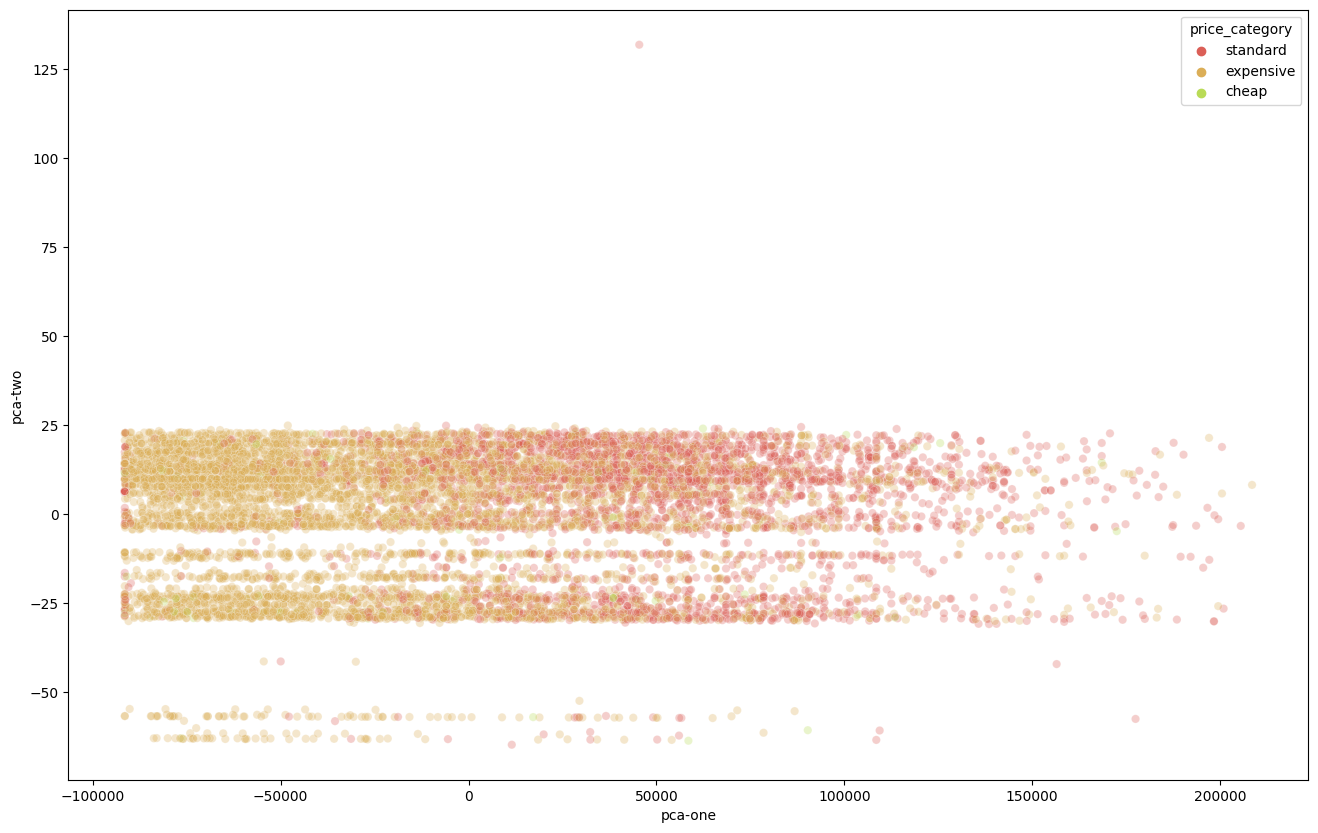

In [14]:
from sklearn.decomposition import PCA

def price_category(row):
    price = row['price']
    price_category = 'cheap'
    if price >= 1000 and price < 10000:
        price_category = 'standard'
    if price >= 10000:
        price_category = 'expensive'
    return price_category

df_subset = train_data.copy().loc[:10000, :]
df_subset['price_category'] = df_subset.apply(price_category, axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_subset[data.train_features].values)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="price_category",
    palette=sns.color_palette("hls", 10),
    data=df_subset.loc[:10000,:],
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.009s...
[t-SNE] Computed neighbors for 10001 samples in 0.696s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 127.276436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.789993
[t-SNE] 

The palette list has more values (10) than needed (3), which may not be intended.


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

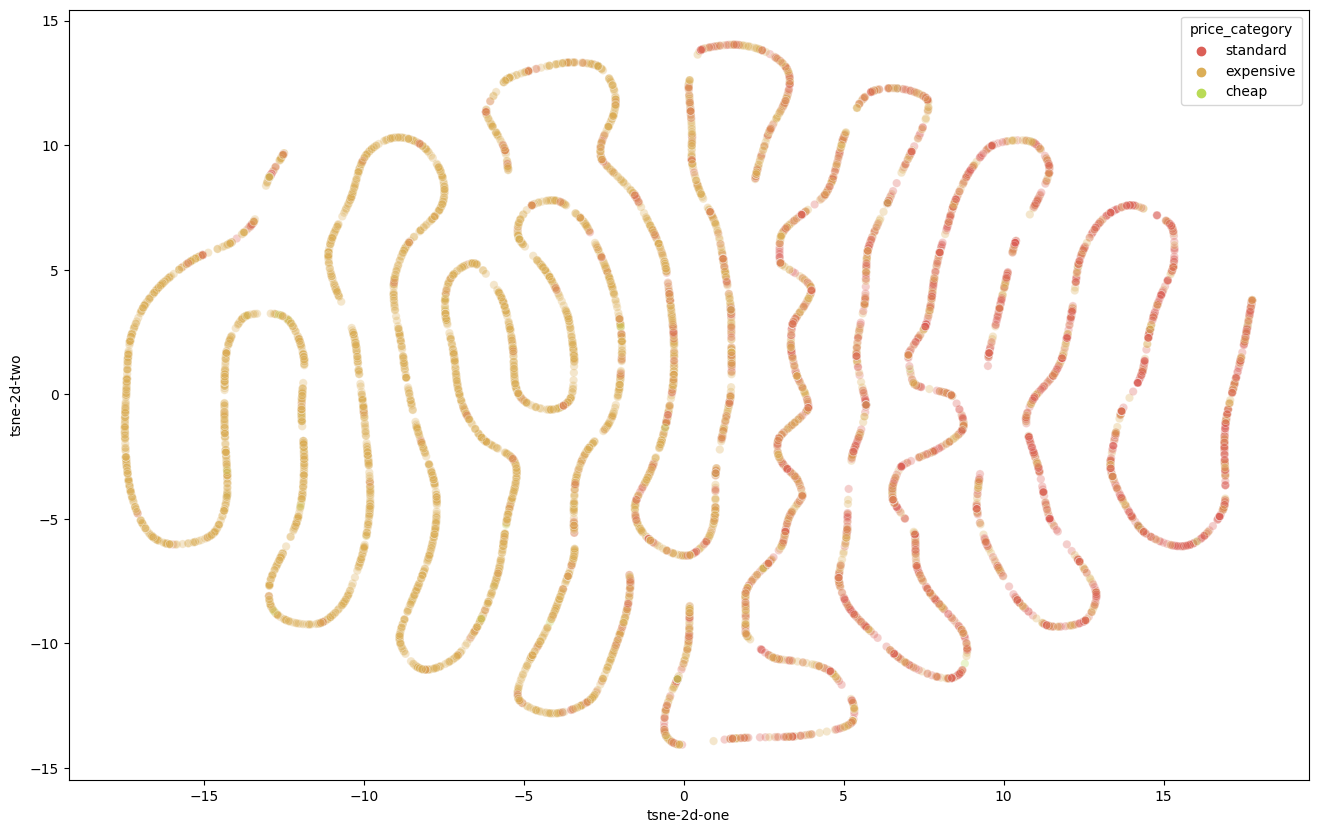

In [15]:
from sklearn.manifold import TSNE

df_subset = train_data.copy().loc[:10000, :]
df_subset['price_category'] = df_subset.apply(price_category, axis=1)

# cols = ['year', 'odometer',]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_subset[data.train_features].values)

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="price_category",
    palette=sns.color_palette("hls", 10),
    data=df_subset.loc[:10000,:],
    legend="full",
    alpha=0.3
)